In [1]:
import sys
import os
sys.path.append(os.getcwd()+'/src/')
%load_ext autoreload
%autoreload 2

In [4]:
from stable_baselines3 import PPO
import torch
import numpy as np

In [19]:
model = PPO.load('../best_model/ppo/MlpPolicy/best_model.zip')
X = np.load('../best_model/ppo/MlpPolicy/observations.npy')
X = torch.Tensor(X)
X.shape

torch.Size([14, 1, 7])

In [8]:
net = model.policy
net.eval()

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (shared_net): Sequential()
    (policy_net): Sequential(
      (0): Linear(in_features=7, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=7, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=64, out_features=7, bias=True)
  (value_net): Linear(in_features=64, out_features=1, bias=True)
)

In [21]:
model.rollout_buffer.observations.shape
np.where(model.rollout_buffer.observations[0] != 0)

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [10]:
rollout = model.rollout_buffer.observations[0:100]
X = torch.Tensor(rollout)

In [48]:
from torch import nn
from stable_baselines3.common.policies import ActorCriticPolicy

class PPOModel(ActorCriticPolicy):
    def __init__(self, observation_space, action_space, lr_schedule):
        super(PPOModel, self).__init__(observation_space, action_space, lr_schedule)
        self.features_extractor = model.policy.features_extractor
        self.mlp_extractor = model.policy.mlp_extractor
        self.action_net = model.policy.action_net
        self.value_net = model.policy.value_net
        
    def forward(self, obs, deterministic: bool = False):
        features = self.extract_features(obs)
        latent_pi, latent_vf = self.mlp_extractor(features)
        values = self.value_net(latent_vf)
        actions = self.action_net(latent_pi)
        return actions

ppo_net = PPOModel(model.observation_space, model.action_space, model.lr_schedule)

In [49]:

x = torch.tensor(X[0])
ppo_net.forward(x)

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([[ 2.1086, -2.6002,  1.6288, -3.4033,  2.3585, -3.5805,  1.2172]],
       grad_fn=<AddmmBackward0>)

In [10]:
from captum.attr import IntegratedGradients

In [42]:
from utils import Utils
from attribute import IGAttributor
from plot import plot_mean_attributions
action_names = Utils.ACTION_NAMES
feature_names = Utils.FEATURE_NAMES

In [44]:
ig_attributor = IGAttributor(net=ppo_net,
                            data=X)
mean_attributions = ig_attributor.get_mean_attributions()

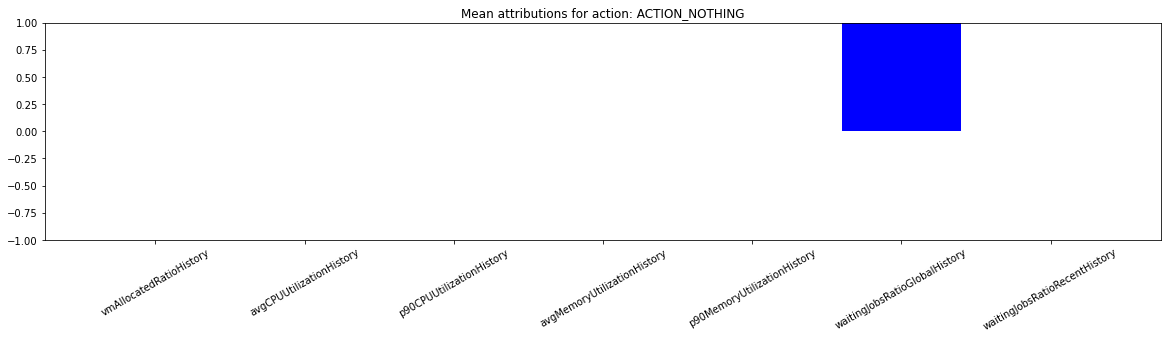

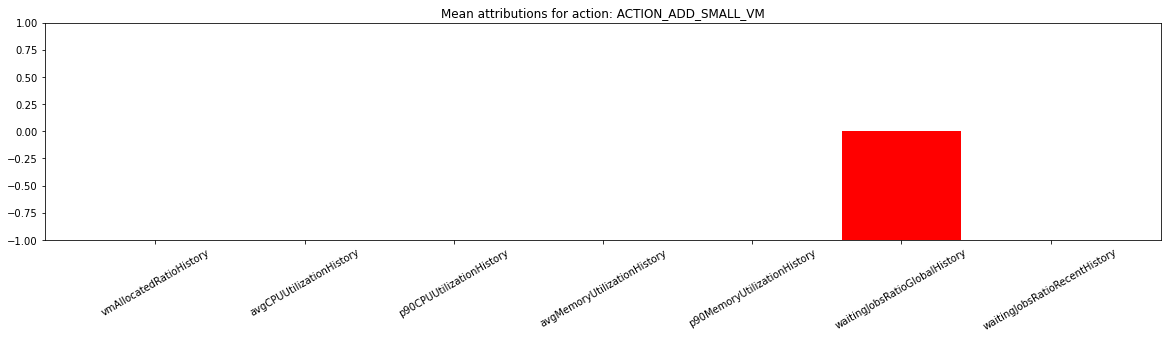

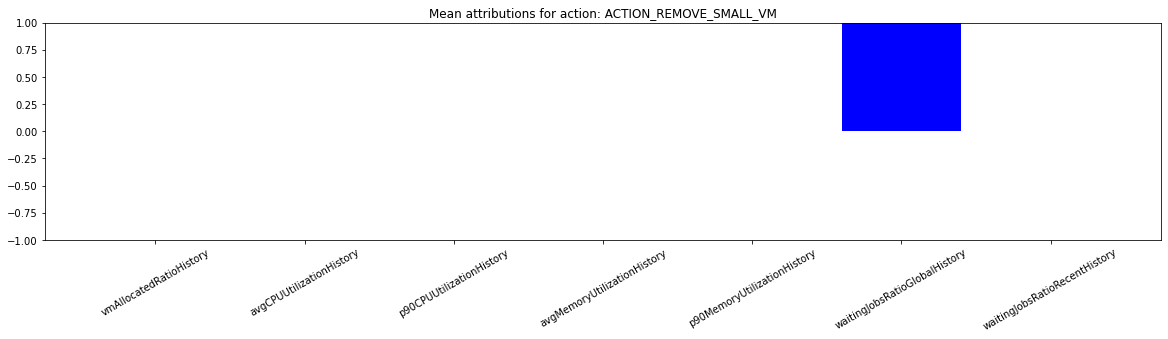

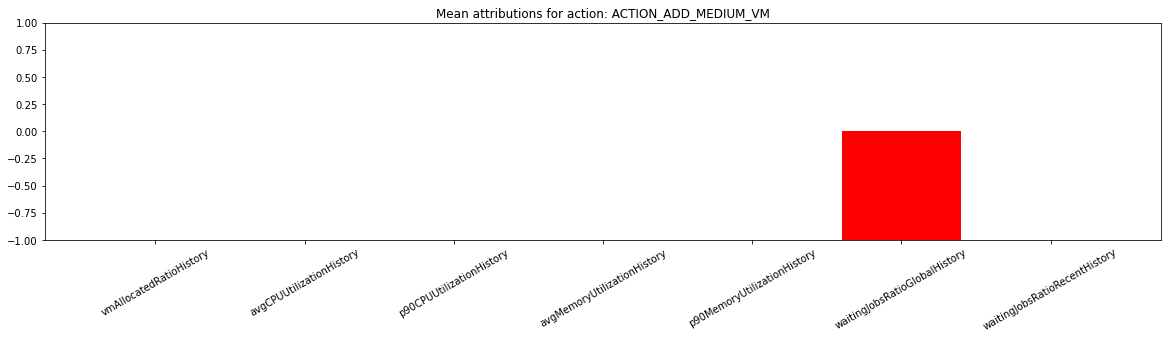

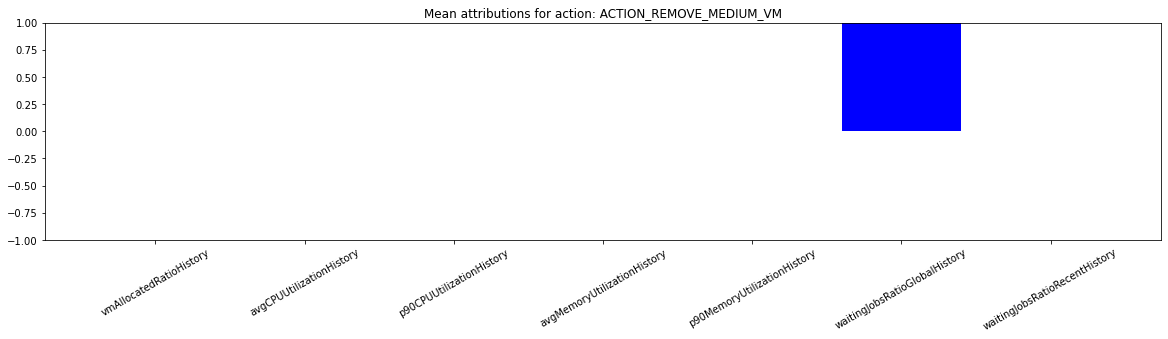

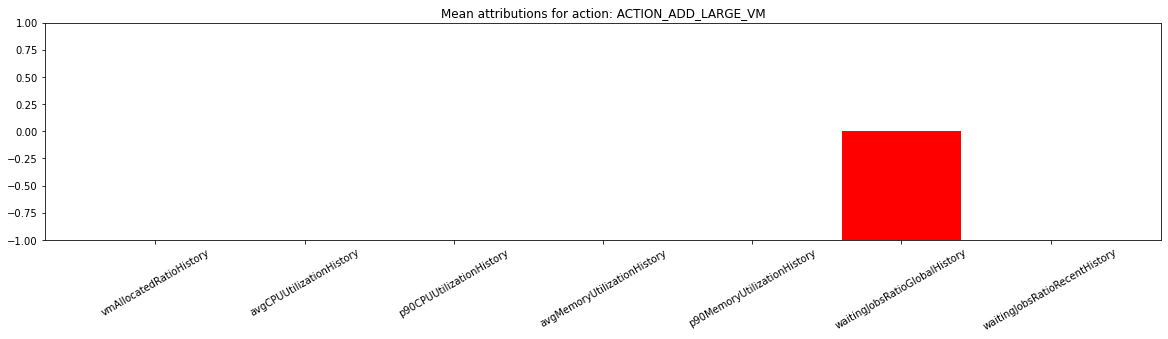

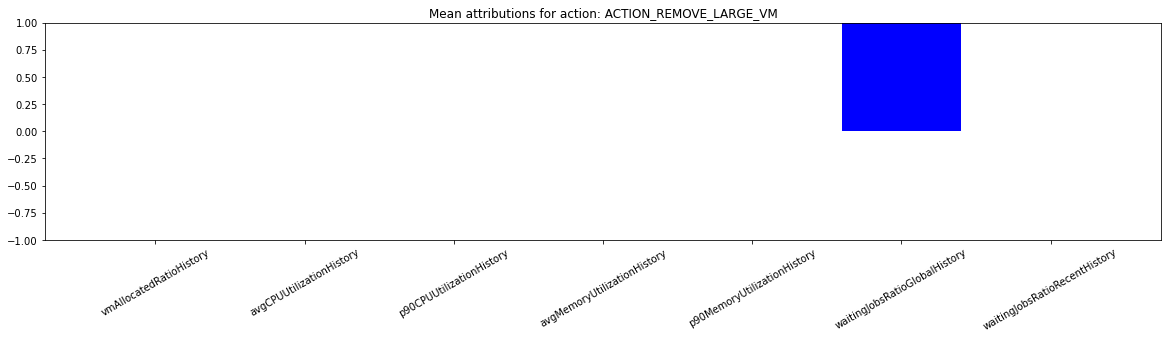

In [45]:
plot_mean_attributions(mean_attributions=mean_attributions)

In [30]:
x_axis_data = np.arange(X.shape[2])

ig = IntegratedGradients(ppo_net)

ig_attr_per_action = [ig.attribute(X, n_steps=50, target=target) for target in range(len(feature_names))]
ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

In [13]:

ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

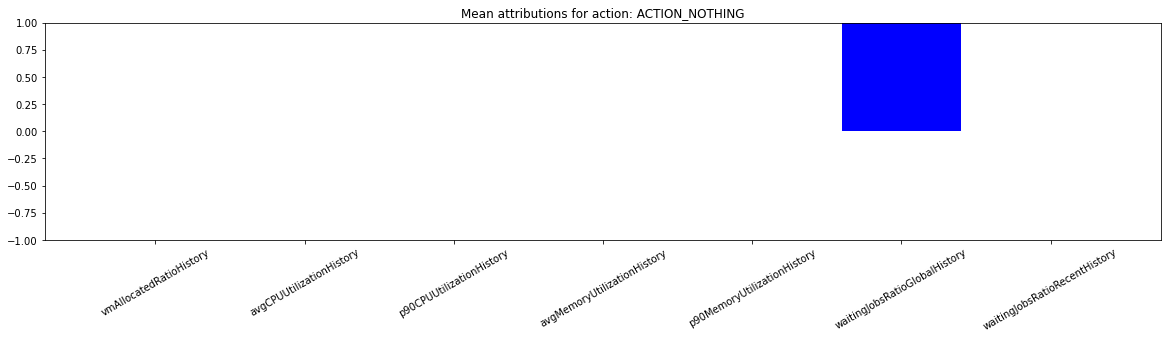

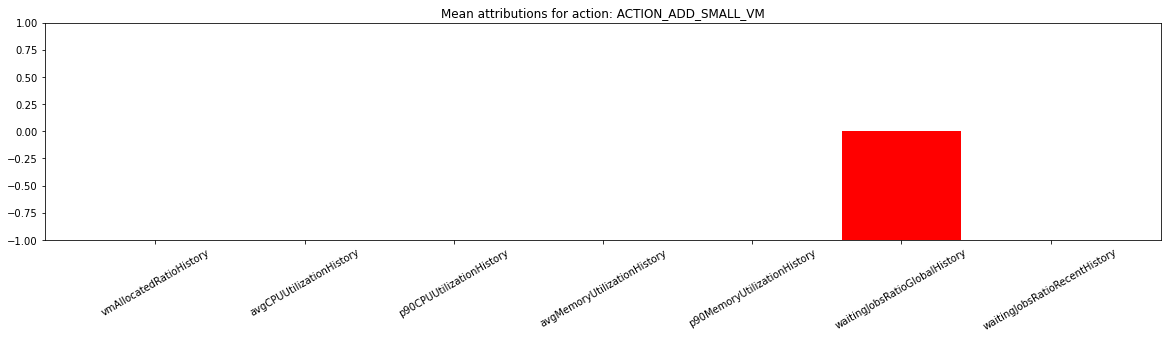

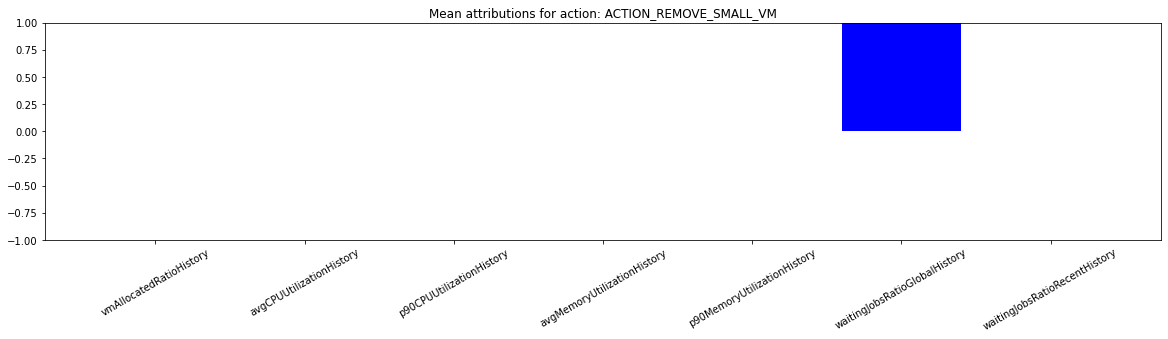

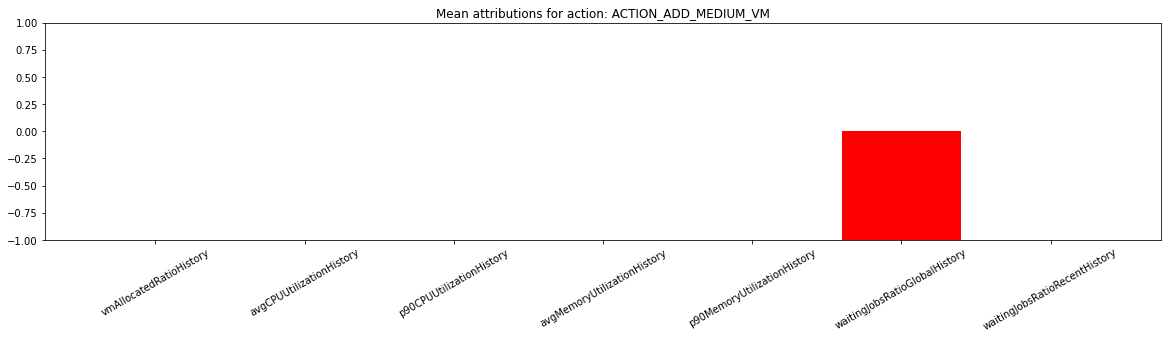

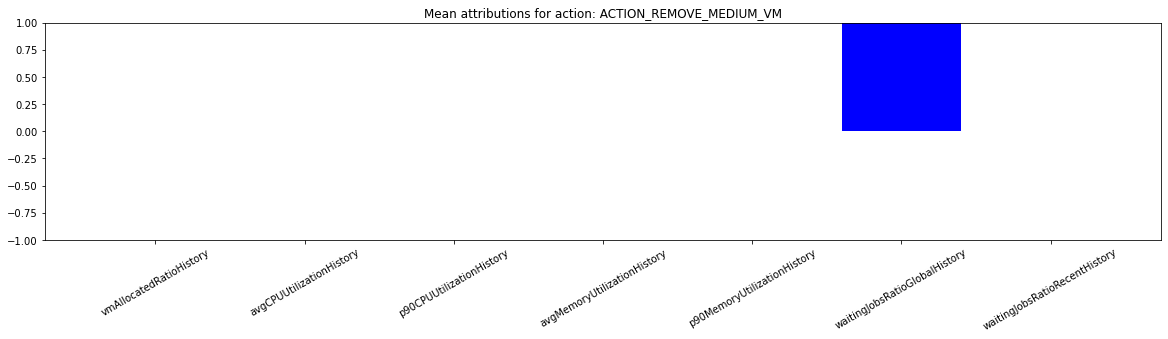

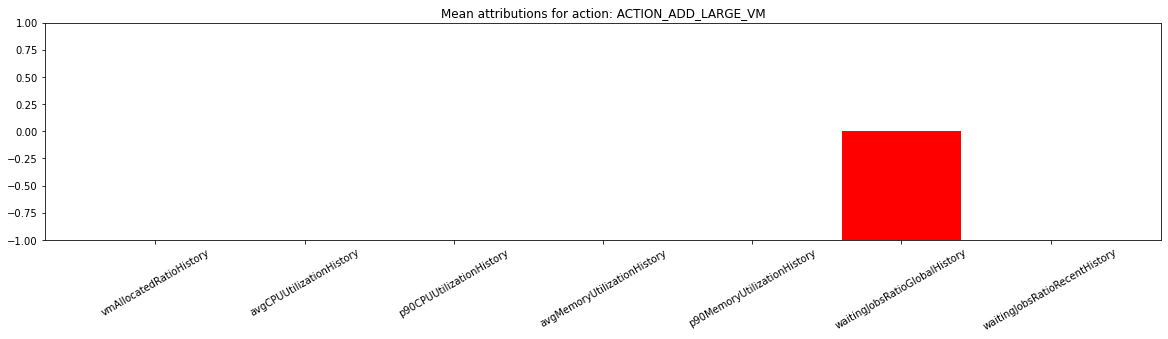

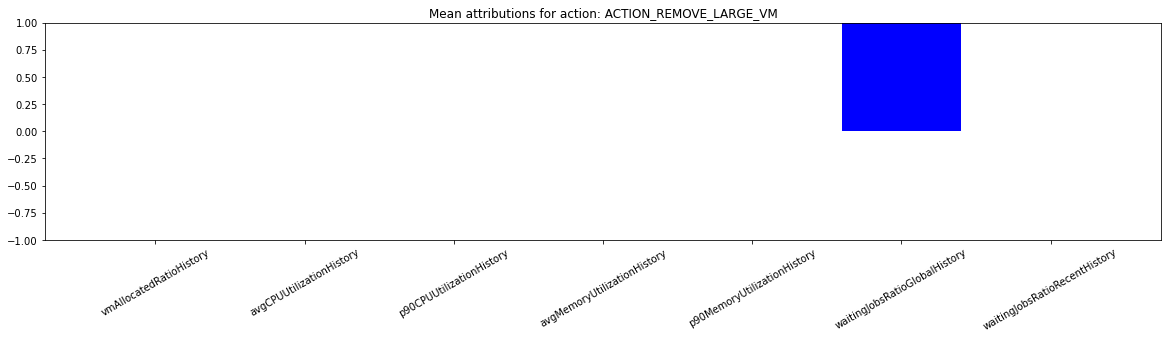

In [31]:
import matplotlib.pyplot as plt

for i, ig_attr in enumerate(ig_attr_test_norm_sum):
    plt.figure(figsize=(20, 4))
    plt.title(f'Mean attributions for action: {action_names[i]}')
    plt.xticks(x_axis_data, feature_names, rotation=30)
    plt.ylim([-1, 1])
    col = []
    for val in ig_attr[0]:
        if val < 0.0:
            col.append('red')
        else:
            col.append('blue')
    plt.bar(x_axis_data, ig_attr[0], color=col)

In [32]:
def render_env(img, feature_names):
    plt.figure(figsize=(20, 4))
    col = []
    for val in img:
        if val < 0.0:
            col.append('red')
        else:
            col.append('blue')
    plt.xticks(range(7), feature_names, rotation=30)
    plt.bar(range(7), img, color=col)
    plt.title('Environment state')
    plt.show()

In [35]:
def explain_action(idx, X, attributions, x_axis_data, feature_names, action_names, model, state=None):
    img = X[idx][0].numpy()
    q_values = model.forward(X[idx]).detach().numpy()
    action = np.argmax(q_values)
    
    print(f'Action made: {action_names[action]}')
    
    render_env(img=img,
           feature_names=feature_names)
    
    fig, axs = plt.subplots(len(attributions), 1, figsize=(20, 20), sharex=True)
    plt.xticks(x_axis_data, feature_names, rotation=30)
    for i, ig_attr in enumerate(attributions):
        axs[i].set_title(f'Attributions for action: {action_names[i]}')
        col = []
        ig_attr = ig_attr.numpy()[idx][0]
        for val in ig_attr:
            if val < 0.0:
                col.append('red')
            else:
                col.append('blue')
        axs[i].bar(x_axis_data, ig_attr, color=col)
    


Action made: ACTION_REMOVE_MEDIUM_VM


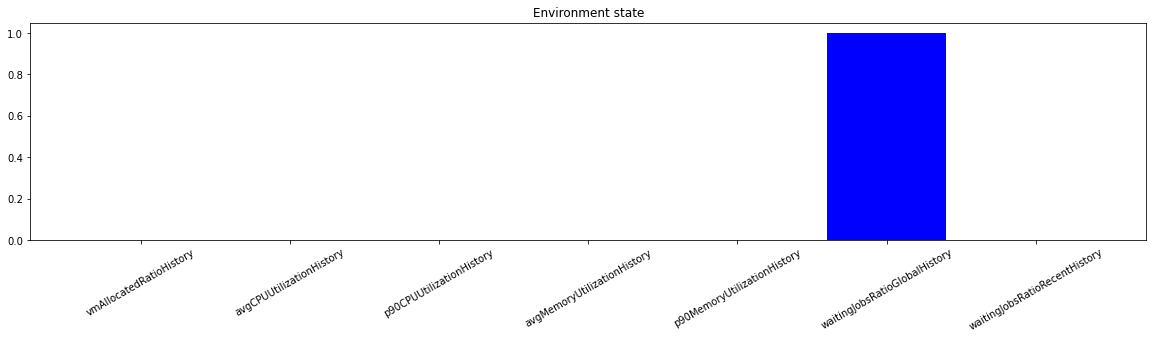

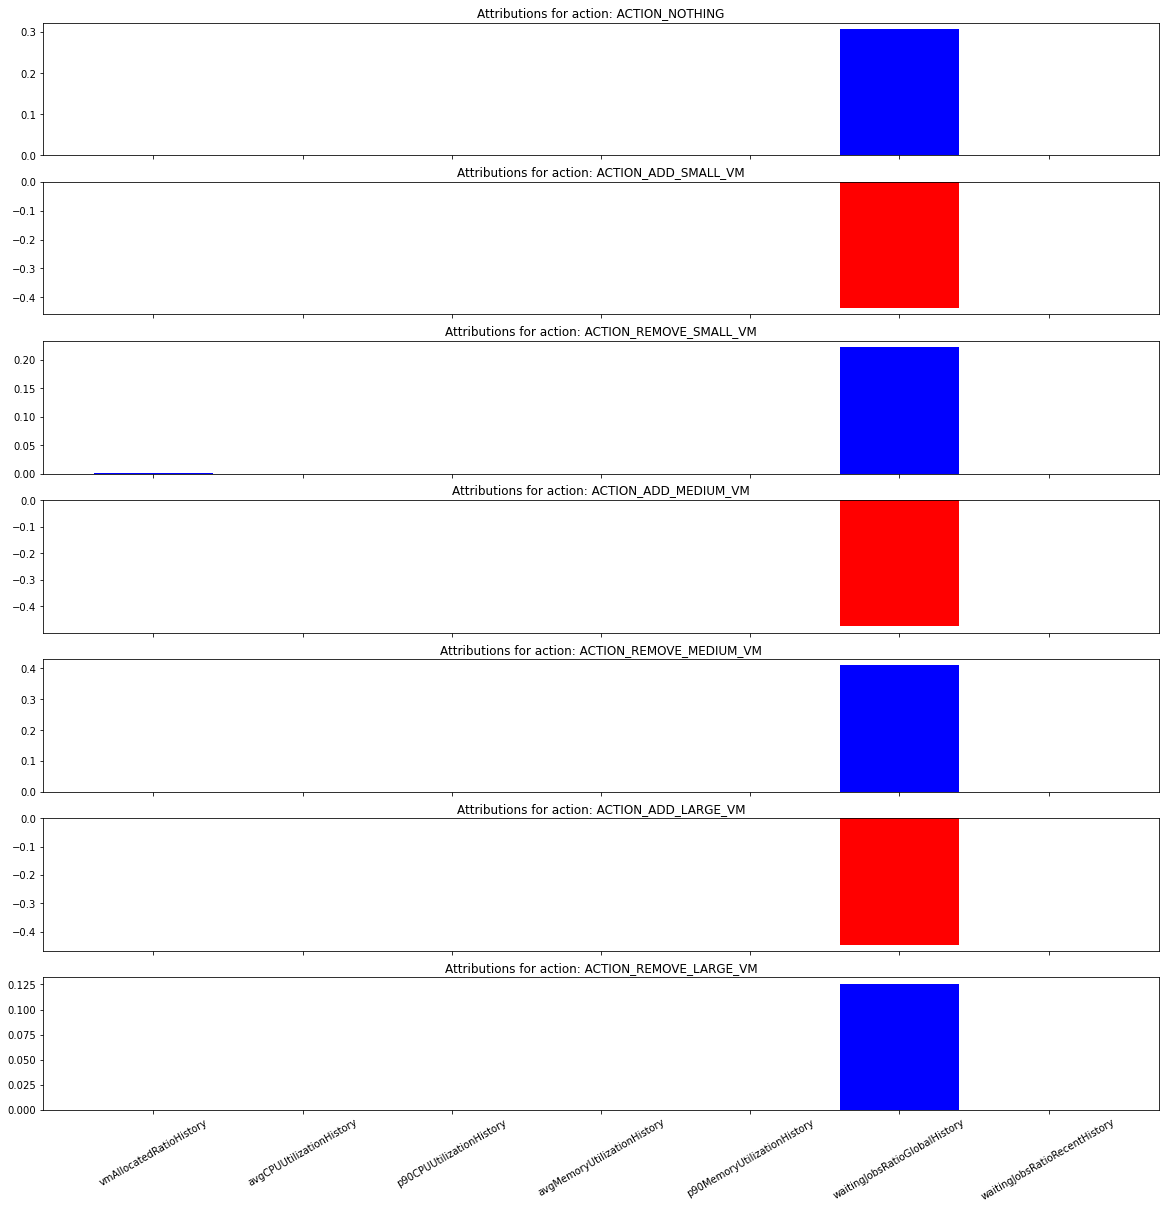

In [37]:
explain_action(idx=0,
               X=X,
               attributions=ig_attr_per_action,
               x_axis_data=x_axis_data,
               feature_names=feature_names,
               action_names=action_names,
               model=ppo_net,
              )

In [86]:
X_manual = torch.Tensor([[[0, 1, 1, 1, 1, 1, 1]]])

In [120]:
X_manual = torch.Tensor([[[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]]])

In [127]:
X_manual = torch.Tensor([[[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]])

In [124]:
X_manual.shape

torch.Size([1, 1, 7])

In [128]:
x_axis_data = np.arange(X_manual.shape[2])

ig = IntegratedGradients(net)

ig_attr_per_action = [ig.attribute(X_manual, n_steps=50, target=target) for target in range(len(action_names))]
ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

Action made: ACTION_REMOVE_MEDIUM_VM


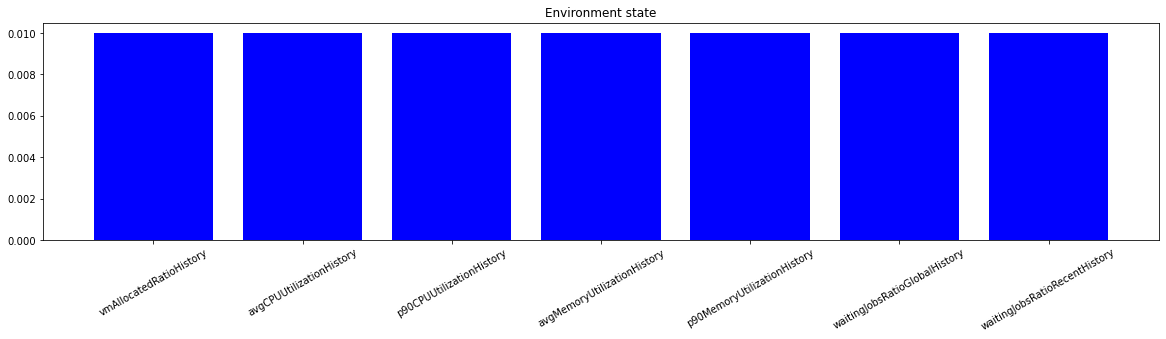

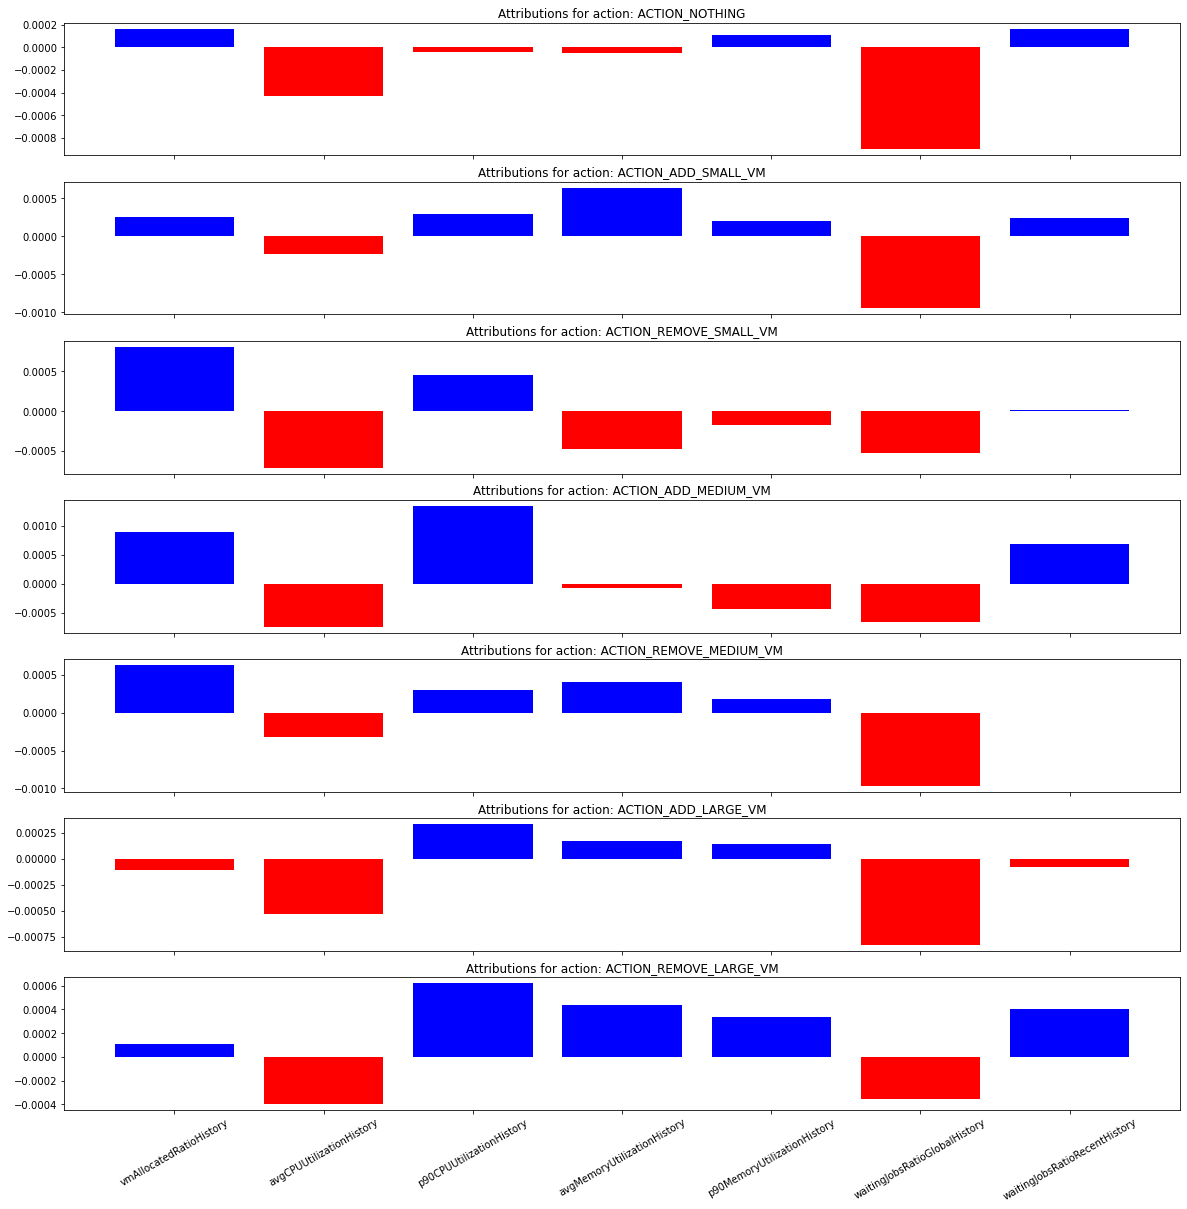

In [129]:
explain_action(idx=0,
               X=X_manual,
               attributions=ig_attr_per_action,
               x_axis_data=x_axis_data,
               feature_names=feature_names,
               action_names=action_names,
               model=model,
              )